In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as random
%matplotlib inline
from casadi import *

In [2]:
#Ce fichier charge et trace 3 trajectoires humaines différentes avec différentes positions de départ et orientations :
#- human_traj_1 commence théoriquement à partir de (-4,-0,9,-pi/2)
#- human_traj_2 commence théoriquement à partir de (-1.5,1.2,0)
#- human_traj_3 commence théoriquement à partir de (-4,-3.4,pi/2)
# La position de but est toujours (0,0,pi/2).

#Les fichiers sont organisés comme suit :
#- de 0 à 5 : trajectoire moyenne (0->x,1->y,2->vx,3->vy,4->theta local,5->theta global)
#- de 6 à 11 : trajectoire du suject 1
#- de 12 à 17 : trajectoire du suject 2
#- de 18 à 23 : trajectoire du suject 3
#- de 24 à 29 : trajectoire du suject 4
#- de 30 à 35 : trajectoire du suject 5
#- de 36 à 41 : trajectoire du suject 6
#- de 42 à 47 : trajectoire du suject 7
#- de 48 à 53 : trajectoire du suject 8
#- de 54 à 59 : trajectoire du suject 9
#- de 60 à la fin : trajectoire du suject 10



In [3]:
def plot_traj(name,ind):
    plt.subplot(1,3,ind+1)
    m = np.loadtxt(name)
    plt.plot(m[0],m[1],color='green',label='mean traj')
    plt.plot(m[6],m[7],color='green',linewidth=0.75,alpha = 0.5,label='individual traj')
    plt.plot(m[12],m[13],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[18],m[19],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[24],m[25],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[30],m[31],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[36],m[37],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[42],m[43],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[48],m[49],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[54],m[55],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[60],m[61],color='green',linewidth=0.75,alpha = 0.5)
    plt.ylabel("y (m)")
    plt.xlabel("x (m)")
    plt.legend()

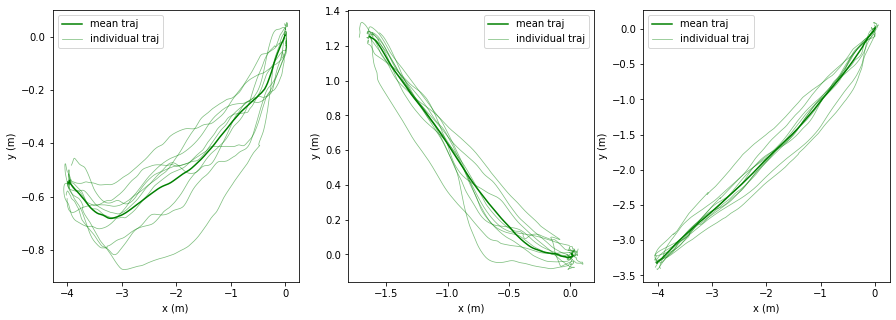

In [5]:
end = 100
time = np.arange(0,end,0.2)
list_name = ["human_traj_1.dat","human_traj_2.dat","human_traj_3.dat"]


plt.figure(figsize = (15,5))
for i in range(len(list_name)):
    plot_traj(list_name[i], i)

plt.show()

# Modèle Unicycle

### DOC

In [6]:
n = 500
T = 2.5
taux = T/n
taux1 = 1/n

In [7]:
def Unicycle_DOC ( Xi , Xf , c1 , c2) :
    x1i = Xi[0] 
    x2i = Xi[1]
    x3i = Xi[2]
    
    x1f = Xf[0] 
    x2f = Xf[1]
    x3f = Xf[2]
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    u1 = opti.variable(n)
    u2 = opti.variable(n)
    x1 = opti.variable(n)
    x2 = opti.variable(n)
    x3 = opti.variable(n)

    opti.minimize(   (taux1/2)*(c1*dot(u1,u1)+c2*dot(u2,u2))   )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
    opti.subject_to( x1[0]==x1i)        
    opti.subject_to( x2[0]==x2i)
    opti.subject_to( x3[0]==x3i)

    opti.subject_to( u1[0] >= 0.0001 )
    opti.subject_to( u1[0] <= 0.01)
    opti.subject_to( u2[0] >= 0.0001 )
    opti.subject_to( u2[0] <= 0.01)
    opti.subject_to( u1[-1] <= 0.001)
    opti.subject_to( u2[-1] <= 0.001)

    ## pour les contraintes d'égaliter
    opti.subject_to( x1[:n-1]+taux1*u1[:n-1]*cos(x3[:n-1])==x1[1:] )
    opti.subject_to( x2[:n-1]+taux1*u1[:n-1]*sin(x3[:n-1])==x2[1:] )
    opti.subject_to( x3[:n-1]+taux1*u2[:n-1] ==x3[1:])

    ## pour les conditions finales
    opti.subject_to( x1[-1]==x1f)
    opti.subject_to( x2[-1]==x2f)
    opti.subject_to( x3[-1]==x3f)


    opti.solver('ipopt')      # suivant la méthode de KKT


    sol = opti.solve()
    
    X1 = sol.value(x1)
    X2 = sol.value(x2)
    X3 = sol.value(x3)
    
    U1 = sol.value(u1)
    U2 = sol.value(u2)
    
    return X1,X2,X3,U1,U2

### IOC 

In [8]:
x1i = SX.sym('x1i',1)                   
x2i = SX.sym('x2i',1)                
x3i = SX.sym('x3i',1)


x1f = SX.sym('x1f',1)
x2f = SX.sym('x2f',1)
x3f = SX.sym('x3f',1)


c1 = SX.sym('c1',1)
c2 = SX.sym('c2',1)

u1=SX.sym('u1',n)  
u1_prime = SX.sym('u1_prime', n+1)
u1_prime[0] = 0
u1_prime[n] = 0
u1_prime[1:n] =u1[0:n-1]

u2=SX.sym('u2',n)  
u2_prime = SX.sym('u2_prime', n+1)
u2_prime[0] = 0
u2_prime[n] = 0
u2_prime[1:n] =u2[0:n-1]

x1=SX.sym('x1',n)
x1_prime = SX.sym('x1_prime', n+1)
x1_prime[0] = x1[0]
x1_prime[1:] =x1


x2=SX.sym('x2',n)
x2_prime = SX.sym('x1_prime', n+1)
x2_prime[0] = x2[0]
x2_prime[1:] =x2

x3=SX.sym('x3',n)
x3_prime = SX.sym('x1_prime', n+1)
x3_prime[0] = x3[0]
x3_prime[1:] =x3

Lambda = SX.sym('Lambda',n+1, 3)
Mue = SX.sym('Mue',2, 3)


In [9]:
p1=vertcat(x1i,x1_prime[2:],x1f)   # Je définis un nouveau vecteur suivant x1 en prenant les n-1 dernières valeurs 
                               #  et la nième valeur vaut x1f
g= Function('g',[x1, x1i, x1f],[p1])

In [10]:
Y1 = (x1_prime+taux*u1_prime*cos(x3_prime) - g(x1,x1i,x1f))
Y2 = (x2_prime+taux*u1_prime*sin(x3_prime) - g(x2,x2i,x2f)) 
Y3 = (x3_prime+taux*u2_prime - g(x3,x3i,x3f))
Y = SX.sym('Y',n+1 , 3)        ## notre contrainte

for i in range (n+1):
    Y[i,0]= Y1[i]
    Y[i,1]= Y2[i]
    Y[i,2]= Y3[i]       

M = SX.sym('M',2 , 3)

M[0,0] = u1[0]-0.01
M[0,1] = -u1[0]+0.001
M[0,2] = u2[0]-0.01

M[1,0] = -u2[0]+0.001
M[1,1] = u1[-1]-0.01
M[1,2] = u2[-1]-0.01


for i in range (n+1):
    Y[i,0]= Y1[i]
    Y[i,1]= Y2[i]
    Y[i,2]= Y3[i]       
    
Y_function = Function('Y_function', [u1,u2,x1,x2,x3], [Y])

M_ = Function('M_',[u1,u2,x1,x2,x3], [M])

In [11]:
## notre terme qui est relié a la contrainte.
G_lambda = 0

for i in range (n+1):
    G_lambda += dot(Y[i,:], Lambda[i,:])
    
G_lambda += dot(M[0,:], Mue[0,:]) + dot(M[1,:], Mue[1,:])

G = Function('G', [x1,x2,x3, Lambda], [G_lambda])

## notre fonction F 
F_val = (taux/2)*(c1*dot(u1,u1)+c2*dot(u2,u2))


## le Lagrangien 
L_val = F_val + G_lambda
#print(L_val.shape)

In [13]:
grad_L_U = SX.zeros(5, n)
for i in range (n):
    grad_L_U[0,i]= jacobian(L_val, u1[i])
    grad_L_U[1,i]= jacobian(L_val, u2[i])
    grad_L_U[2,i]= jacobian(L_val, x1[i])
    grad_L_U[3,i]= jacobian(L_val, x2[i])
    grad_L_U[4,i]= jacobian(L_val, x3[i])
    
    
R_U = Function ('R_U', [u1,u2,x1,x2,x3, Lambda,Mue, c1, c2, x1i,x2i,x3i, x1f,x2f,x3f ], [(dot(grad_L_U,grad_L_U))])

In [27]:
def Unicycle_IOC (R_U, U1,U2,X1,X2,X3,Xi,Xf) :
    x1i = Xi[0] 
    x2i = Xi[1]
    x3i = Xi[2]
    
    x1f = Xf[0] 
    x2f = Xf[1]
    x3f = Xf[2]

    M = M_(U1,U2,X1,X2,X3)
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    c1    = opti.variable()
    c2    = opti.variable()

    Lambda = opti.variable(n+1,3)
    Mue = opti.variable(2,3)

    
    opti.minimize( R_U(U1,U2,X1,X2,X3, Lambda,Mue,  c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ))  

    opti.subject_to( 0 <= c1)
    opti.subject_to( 0 <= c2 )
    opti.subject_to(  c1 + c2 == 1)
    for i in range (2):
        for j in range (3) :
            opti.subject_to( 0 <= Mue[i,j])

    opti.subject_to( dot(M[0,:], Mue[0,:]) + dot(M[1,:], Mue[1,:]) == 0 )

    opti.solver('ipopt')      

    sol = opti.solve()
    
    return sol.value(c1), sol.value(c2) , sol.value(Lambda), sol.value(Mue)

# Modèle Katja Mombaur

## DOC

In [15]:
x = SX.sym('x', n )
p =vertcat(x[1:],0)
f1 = Function ('f1',[x],[p])

In [16]:
def Katja_Mombaur_DOC ( Xi, Xf, alpha1, alpha2, alpha3):
    xi = Xi[0] 
    yi = Xi[1]
    thetai = Xi[2]
    
    xf = Xf[0] 
    yf = Xf[1]
    thetaf = Xf[2]
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    ## les positions
    x = opti.variable(n)
    y = opti.variable(n)
    theta = opti.variable(n)

    ## les vitesses 
    v1 = opti.variable(n)        ## vitesse latérale
    v2 = opti.variable(n)        ## vitesse orthogonal
    w = opti.variable(n)         ## vitesse angulaire
    
        ## les vitesses 
    u1 = opti.variable(n)        ## accélération latérale
    u3 = opti.variable(n)        ## accélération orthogonal
    u2 = opti.variable(n)        ## accélération angulaire
    
    
    
    opti.minimize(  taux*(alpha1 * dot(u1,u1) + alpha2 * dot(u2,u2 ) + alpha3 * dot( u3 ,u3 ) ) )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
    opti.subject_to( x[0] == xi)        
    opti.subject_to( y[0] == yi)
    opti.subject_to( theta[0] == thetai)


    opti.subject_to( v1[0] <= 0.01 )
    opti.subject_to( w[0] <= 0.01 )
    opti.subject_to( v2[0] <= 0.01 )
    opti.subject_to( v1[0] >= 0.0001 )
    opti.subject_to( w[0] >= 0.0001 )
    opti.subject_to( v2[0] >= 0.0001 )

    opti.subject_to( v1[-1] <= 0.01 )
    opti.subject_to( w[-1] <= 0.01 )
    opti.subject_to( v2[-1] <= 0.01 )
    opti.subject_to( v1[-1] >= 0.0001 )
    opti.subject_to( w[-1] >= 0.0001 )
    opti.subject_to( v2[-1] >= 0.0001 )

    opti.subject_to( u1[0] <= 0.01 )
    opti.subject_to( u2[0] <= 0.01 )
    opti.subject_to( u3[0] <= 0.01 )
    opti.subject_to( u1[-1] <= 0.01 )
    opti.subject_to( u2[-1] <= 0.01 )
    opti.subject_to( u3[-1] <= 0.01 )

    ## pour les contraintes d'égaliter
    opti.subject_to( x[1:] == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
    opti.subject_to( y[1:] == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
    opti.subject_to( theta[1:] == theta[:n-1] + taux*w[:n-1] )
    opti.subject_to( (v1[:n-1] + taux* u1[:n-1] == v1[1:])  )
    opti.subject_to( (v2[:n-1] + taux* u3[:n-1] == v2[1:]) )
    opti.subject_to( (w[:n-1] + taux* u2[:n-1] == w[1:]) )
    

    ## pour les conditions finales
    opti.subject_to( x[-1]==xf)
    opti.subject_to( y[-1]==yf)
    opti.subject_to( theta[-1]==thetaf)


    opti.solver('ipopt')      # suivant la méthode de KKT


    sol = opti.solve()
    
    
    X = sol.value(x)
    Y = sol.value(y)
    THETA = sol.value(theta)
    
    V1 = sol.value(v1)
    V2 = sol.value(v2)
    W = sol.value(w)
    
    U1 = sol.value(u1)
    U2 = sol.value(u2)
    U3 = sol.value(u3)
    
    return X,Y,THETA, V1,V2,W, U1,U2,U3

## IOC

In [17]:
xi = SX.sym('xi',1)                   
yi = SX.sym('yi',1)                
thetai = SX.sym('thetai',1)


xf = SX.sym('xf',1)
yf = SX.sym('yf',1)
thetaf = SX.sym('thetaf',1)

alpha1 = SX.sym('alpha1',1)
alpha2 = SX.sym('alpha2',1)
alpha3 = SX.sym('alpha3',1)

## Position
x=SX.sym('x',n)
x_prime = SX.sym('x_prime', n+1)
x_prime[0] = x[0]
x_prime[1:] =x


y=SX.sym('y',n)
y_prime = SX.sym('y_prime', n+1)
y_prime[0] = y[0]
y_prime[1:] =y

theta=SX.sym('theta',n)
theta_prime = SX.sym('theta_prime', n+1)
theta_prime[0] = theta[0]
theta_prime[1:] =theta


## Vitesse
v1=SX.sym('v1',n)  
v1_prime = SX.sym('v1_prime', n+1)
v1_prime[0] = 0
v1_prime[n] = 0
v1_prime[1:n] =v1[0:n-1]

v1_prime_1 = SX.sym('v1_prime_1', n+1)
v1_prime_1[0] = v1[0]
v1_prime_1[1:] =v1


v2=SX.sym('v2',n)  
v2_prime = SX.sym('v2_prime', n+1)
v2_prime[0] = 0
v2_prime[n] = 0
v2_prime[1:n] =v2[0:n-1]

v2_prime_1 = SX.sym('v2_prime_1', n+1)
v2_prime_1[0] = v2[0]
v2_prime_1[1:] =v2


w=SX.sym('w',n)  
w_prime = SX.sym('w_prime', n+1)
w_prime[0] = 0
w_prime[n] = 0
w_prime[1:n] =w[0:n-1]

w_prime_1 = SX.sym('w_prime_1', n+1)
w_prime_1[0] = w[0]
w_prime_1[1:] =w


## Accélération 

u1=SX.sym('u1',n)  
u1_prime = SX.sym('u1_prime', n+1)
u1_prime[0] = 0
u1_prime[n] = 0
u1_prime[1:n] = u1[0:n-1]

u2=SX.sym('u2',n)  
u2_prime = SX.sym('u2_prime', n+1)
u2_prime[0] = 0
u2_prime[n] = 0
u2_prime[1:n] = u2[0:n-1]

u3=SX.sym('u3',n)  
u3_prime = SX.sym('u3_prime', n+1)
u3_prime[0] = 0
u3_prime[n] = 0
u3_prime[1:n] = u3[0:n-1]

Lambda = SX.sym('Lambda',n+1, 6)
Mue = SX.sym('Mue',3, 6)


In [18]:
p1=vertcat(xi,x_prime[2:],xf)   # Je définis un nouveau vecteur suivant x1 en prenant les n-1 dernières valeurs 
                               #  et la nième valeur vaut x1f
h= Function('h',[x, xi, xf],[p1])

p2=vertcat(0, v1)   
K = Function('K', [v1], [p2])

p =vertcat(v1[1:],0)
g = Function ('g',[v1],[p])

In [20]:
Y1_K = (x_prime+taux*(v1_prime*cos(theta_prime) - v2_prime*sin(theta_prime)) - h(x, xi,xf))
Y2_K = (y_prime+taux*(v1_prime*sin(theta_prime) + v2_prime*cos(theta_prime)) - h(y, yi,yf)) 
Y3_K = (theta_prime+taux*w_prime - h(theta, thetai,thetaf))

U1 = (g(v1)-v1)/taux - u1
U2 = (g(w)-w)/taux  - u2
U3 = (g(v2)-v2)/taux  - u3 

Y4_K = K(U1) 
Y5_K = K(U2)
Y6_K = K(U3)


Y_K = SX.sym('Y_K',n+1 , 6)        ## notre contrainte

for i in range (0,n+1):
    Y_K[i,0]= Y1_K[i]
    Y_K[i,1]= Y2_K[i]
    Y_K[i,2]= Y3_K[i]       
    Y_K[i,3]= Y4_K[i]       
    Y_K[i,4]= Y5_K[i]       
    Y_K[i,5]= Y6_K[i]      


M = SX.sym('M',3 , 6)

M[0,0] = v1[0] - 0.01 
M[0,1] = w[0] - 0.01 
M[0,2] = v2[0] - 0.01 
M[0,3] = -v1[0] + 0.0001 
M[0,4] = -w[0] + 0.0001 
M[0,5] = -v2[0] + 0.0001 

M[1,0] = v1[-1] - 0.01 
M[1,1] = w[-1] - 0.01 
M[1,2] = v2[-1] - 0.01 
M[1,3] = -v1[-1] + 0.0001 
M[1,4] = -w[-1] + 0.0001 
M[1,5] = -v2[-1] + 0.0001 


M[2,0] = u1[0] - 0.01 
M[2,1] = u2[0] - 0.01 
M[2,2] = u3[0] - 0.01 
M[2,3] = u1[-1] - 0.01 
M[2,4] = u2[-1] - 0.01 
M[2,5] = u3[-1] - 0.01

G = Function('G', [u1,u2,u3,v1,w,v2,x,y,theta], [M]) 
    
## notre terme qui est relié a la contrainte.
G_lambda = 0

for i in range (n+1):
    G_lambda += dot(Y_K[i,:], Lambda[i,:])

G_lambda += dot(M[0,:], Mue[0,:]) + dot(M[1,:], Mue[1,:]) + dot(M[2,:], Mue[2,:])


In [21]:
F_val_K =  taux*( alpha1 * dot(u1,u1) + alpha2 * dot(u2,u2) + alpha3 * dot(u3,u3))

## le Lagrangien 
L_val_K = F_val_K + G_lambda

In [22]:
grad_L_K = SX.zeros(9, n)
for i in range (n):
    grad_L_K[0,i]= jacobian(L_val_K, v1[i])
    grad_L_K[1,i]= jacobian(L_val_K, w[i])
    grad_L_K[2,i]= jacobian(L_val_K, v2[i])
    grad_L_K[3,i]= jacobian(L_val_K, x[i])
    grad_L_K[4,i]= jacobian(L_val_K, y[i])
    grad_L_K[5,i]= jacobian(L_val_K, theta[i])
    grad_L_K[6,i]= jacobian(L_val_K, u1[i])
    grad_L_K[7,i]= jacobian(L_val_K, u2[i])
    grad_L_K[8,i]= jacobian(L_val_K, u3[i])
    
    
    
R_K = Function ('R_K', [u1,u2,u3,v1,w,v2,x,y,theta, Lambda, Mue, alpha1, alpha2, alpha3 ,xi,yi,thetai, xf,yf,thetaf  ], [dot(grad_L_K,grad_L_K)])
    

In [28]:
def Katja_Mombaur_IOC (R_K,U1,U2,U3 ,V1,V2,W,X,Y,THETA,Xi,Xf) :
    xi = Xi[0] 
    yi = Xi[1]
    thetai = Xi[2]
    
    xf = Xf[0] 
    yf = Xf[1]
    thetaf = Xf[2]

    M = G(U1,U2,U3,V1,W,V2,X,Y,THETA)
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    alpha1 = opti.variable()
    alpha2 = opti.variable()
    alpha3 = opti.variable()
    Lambda = opti.variable(n+1,6)
    Mue = opti.variable(3,6)

    
    opti.minimize( R_K(U1,U2,U3,V1,W,V2,X,Y,THETA, Lambda,Mue,  alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )) 

    opti.subject_to( 0 <= alpha1)
    #opti.subject_to( 1 >= alpha1)

    opti.subject_to( 0 <= alpha2 )
    #opti.subject_to( 1 >= alpha2)


    opti.subject_to( 0 <= alpha3 )
    #opti.subject_to( 1 >= alpha3)

    for i in range (3):
        for j in range (6) :
            opti.subject_to( 0 <= Mue[i,j])

    opti.subject_to( dot(M[0,:], Mue[0,:]) + dot(M[1,:], Mue[1,:]) + dot(M[2,:], Mue[2,:]) == 0 )


    opti.subject_to(  alpha1 + alpha2 + alpha3 == 1)



    opti.solver('ipopt')    

    sol = opti.solve()
    
    Alpha1 = sol.value (alpha1)
    Alpha2 = sol.value (alpha2)   
    Alpha3 = sol.value (alpha3)
    
    return Alpha1, Alpha2, Alpha3 , sol.value(Lambda), sol.value(Mue)

# Première trajectoire

In [75]:
T1 = np.loadtxt("human_traj_1.dat")

In [76]:
X1 = T1[0]
X2 = T1[1]
X3 = T1[5]

M = vertcat(X3[1:],0)

U1 = cos(X3)*T1[2]+T1[3]*sin(X3)
U2 = (M-X3)/taux1


Xi = [X1[0],X2[0],X3[0]]
Xf = [X1[-1],X2[-1],X3[-1]]

x1i = X1[0]
x2i = X2[0]
x3i = X3[0]

x1f = X1[-1]
x2f = X2[-1]
x3f = X3[-1]


X = T1[0]
Y = T1[1]
THETA = T1[5]

V1 = T1[2]*cos(X3) + sin(X3)*T1[3]
V2 = -T1[2]*sin(X3) + cos(X3)*T1[3]
W  = (M-T1[5])/taux

M1 = vertcat(V1[1:],0)
M2 = vertcat(W[1:],0)
M3 = vertcat(V2[1:],0)

U1_1 = (M1-V1)/taux
U2_1 = (M2-W)/taux
U3_1 = (M3-V2)/taux

In [77]:
## Puydupin-Jamin

c1, c2, Lambda, Mue = Unicycle_IOC (R_U, U1,U2,X1,X2,X3,Xi,Xf)

Residue_Unicycle_IOC = R_U(U1,U2,X1,X2,X3, Lambda,Mue, c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ) 

X1_S1 ,X2_S1,X3_S1,U1_S1,U2_S1  = Unicycle_DOC ( Xi , Xf , c1 , c2)


## Katja_Mombaur

alpha1, alpha2, alpha3, Lambda, Mue = Katja_Mombaur_IOC (R_K,U1_1,U2_1,U3_1, V1,V2,W,X,Y,THETA,Xi,Xf)

Residue_Mombaur_IOC  = R_K(U1_1,U2_1,U3_1,V1,W,V2,X,Y,THETA, Lambda,Mue, alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )

X_S1,Y_S1,THETA_S1, V1_S1,V2_S1,W_S1, U1_S1,U2_S1,U3_S1 = Katja_Mombaur_DOC (Xi, Xf, alpha1, alpha2, alpha3)


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        8
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:     7017

Total number of variables............................:     1511
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        8
        inequality constraints with only lower bounds:        8
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 6.08e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [78]:
RMSE_unicycle = sqrt((dot(X1-X1_S1, X1-X1_S1 ) + dot(X2-X2_S1, X2-X2_S1 ))/n)
RMSE_Mombaur = sqrt((dot(X1-X_S1, X1-X_S1 ) + dot(X2-Y_S1, X2-Y_S1 ))/n)

In [79]:
print("Puydupin-Jamin")
print("The residu after the IOC : ", Residue_Unicycle_IOC)
print("(c1,c2) = (", c1,",",c2,")")
print("RMSE after the DOC : ",RMSE_unicycle)


print()


print("Katja_Mombaur")
print("The residu after the IOC : ",Residue_Mombaur_IOC)
print("(alpha1,alpha2,alpha3) = (", alpha1,",",alpha2,",",alpha3,")")
print("RMSE after the DOC : ",RMSE_Mombaur)


Puydupin-Jamin
The residu after the IOC :  0.0016671
(c1,c2) = ( 0.9999995765003192 , 4.2349968073944553e-07 )
RMSE after the DOC :  0.47638

Katja_Mombaur
The residu after the IOC :  0.227546
(alpha1,alpha2,alpha3) = ( 0.29933704344982703 , 1.2237030876616436e-05 , 0.7006507195192964 )
RMSE after the DOC :  0.263377


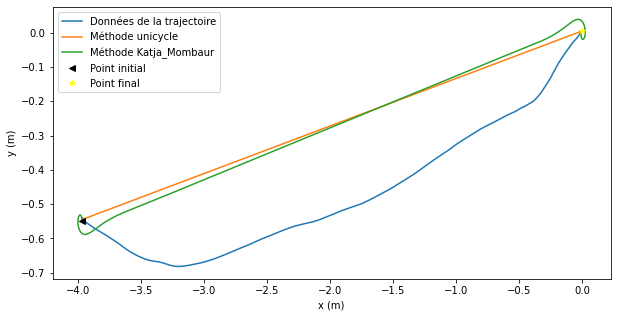

In [80]:
plt.figure(figsize = (10,5))
plt.plot(X1,X2, label = 'Données de la trajectoire' )
plt.plot(X1_S1,X2_S1, label = 'Méthode unicycle')
plt.plot(X_S1,Y_S1, label = 'Méthode Katja_Mombaur')

plt.plot(Xi[0],Xi[1], '<', label = 'Point initial', color = 'black')
plt.plot(Xf[0],Xf[1], '*', label = 'Point final', color = 'yellow')
plt.ylabel("y (m)")
plt.xlabel("x (m)")
plt.legend()

# Deuxième trajectoire


In [81]:
T2 = np.loadtxt("human_traj_2.dat")

In [82]:
X1 = T2[0]
X2 = T2[1]
X3 = T2[5]

M = vertcat(X3[1:],0)

U1 = cos(X3)*T2[2]+T2[3]*sin(X3)
U2 = (M-X3)/taux1


Xi = [X1[0],X2[0],X3[0]]
Xf = [X1[-1],X2[-1],X3[-1]]

x1i = X1[0]
x2i = X2[0]
x3i = X3[0]

x1f = X1[-1]
x2f = X2[-1]
x3f = X3[-1]


X = T2[0]
Y = T2[1]
THETA = T2[5]

V1 = T2[2]*cos(X3) + sin(X3)*T2[3]
V2 = -T2[2]*sin(X3) + cos(X3)*T2[3]
W  = (M-T2[5])/taux

M1 = vertcat(V1[1:],0)
M2 = vertcat(W[1:],0)
M3 = vertcat(V2[1:],0)

U1_1 = (M1-V1)/taux
U2_1 = (M2-W)/taux
U3_1 = (M3-V2)/taux

In [83]:
## Puydupin-Jamin

c1, c2, Lambda, Mue = Unicycle_IOC (R_U, U1,U2,X1,X2,X3,Xi,Xf)

Residue_Unicycle_IOC = R_U(U1,U2,X1,X2,X3, Lambda,Mue, c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ) 

X1_S1 ,X2_S1,X3_S1,U1_S1,U2_S1  = Unicycle_DOC ( Xi , Xf , c1 , c2) 

Residue_Unicycle_DOC = R_U(U1_S1,U2_S1,X1_S1,X2_S1,X3_S1, Lambda,Mue, c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ) 


## Katja_Mombaur

alpha1, alpha2, alpha3, Lambda, Mue = Katja_Mombaur_IOC (R_K,U1_1,U2_1,U3_1, V1,V2,W,X,Y,THETA,Xi,Xf)

Residue_Mombaur_IOC  = R_K(U1_1,U2_1,U3_1,V1,W,V2,X,Y,THETA, Lambda,Mue, alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )

X_S1,Y_S1,THETA_S1, V1_S1,V2_S1,W_S1, U1_S1,U2_S1,U3_S1 = Katja_Mombaur_DOC (Xi, Xf, alpha1, alpha2, alpha3)


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        8
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:     7017

Total number of variables............................:     1511
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        8
        inequality constraints with only lower bounds:        8
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 5.62e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [84]:
RMSE_unicycle = sqrt((dot(X1-X1_S1, X1-X1_S1 ) + dot(X2-X2_S1, X2-X2_S1 ))/n)
RMSE_Mombaur = sqrt((dot(X1-X_S1, X1-X_S1 ) + dot(X2-Y_S1, X2-Y_S1 ))/n)

In [85]:
print("Puydupin-Jamin")
print("The residu after the IOC : ", Residue_Unicycle_IOC)
print("(c1,c2) = (", c1,",",c2,")")
print("RMSE after the DOC : ",RMSE_unicycle)


print()


print("Katja_Mombaur")
print("The residu after the IOC : ",Residue_Mombaur_IOC)
print("(alpha1,alpha2,alpha3) = (", alpha1,",",alpha2,",",alpha3,")")
print("RMSE after the DOC : ",RMSE_Mombaur)



Puydupin-Jamin
The residu after the IOC :  0.000863053
(c1,c2) = ( 0.9999558918484165 , 4.4108151583577496e-05 )
RMSE after the DOC :  0.372322

Katja_Mombaur
The residu after the IOC :  0.217029
(alpha1,alpha2,alpha3) = ( 0.4683525724078349 , 1.5116411531754472e-06 , 0.5316459159510118 )
RMSE after the DOC :  0.310184


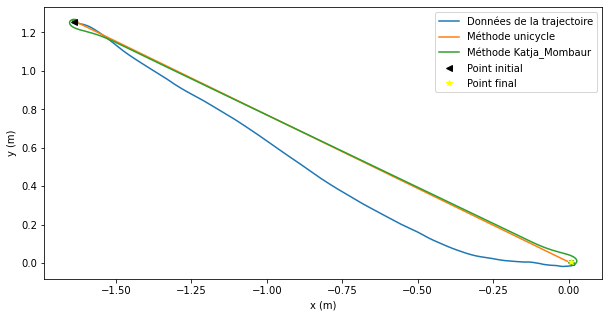

In [86]:
plt.figure(figsize = (10,5))
plt.plot(X1,X2, label = 'Données de la trajectoire' )
plt.plot(X1_S1,X2_S1, label = 'Méthode unicycle')
plt.plot(X_S1,Y_S1, label = 'Méthode Katja_Mombaur')


plt.plot(Xi[0],Xi[1], '<', label = 'Point initial', color = 'black')
plt.plot(Xf[0],Xf[1], '*', label = 'Point final', color = 'yellow')
plt.ylabel("y (m)")
plt.xlabel("x (m)")
plt.legend()

# Troisième trajectoire

In [87]:
T3 = np.loadtxt("human_traj_3.dat")

In [88]:
X1 = T3[0]
X2 = T3[1]
X3 = T3[5]

M = vertcat(X3[1:],0)

U1 = cos(X3)*T3[2]+T3[3]*sin(X3)
U2 = (M-X3)/taux1


Xi = [X1[0],X2[0],X3[0]]
Xf = [X1[-1],X2[-1],X3[-1]]

x1i = X1[0]
x2i = X2[0]
x3i = X3[0]

x1f = X1[-1]
x2f = X2[-1]
x3f = X3[-1]


X = T3[0]
Y = T3[1]
THETA = T3[5]

V1 = T3[2]*cos(X3) + sin(X3)*T3[3]
V2 = -T3[2]*sin(X3) + cos(X3)*T3[3]
W  = (M-T3[5])/taux

M1 = vertcat(V1[1:],0)
M2 = vertcat(W[1:],0)
M3 = vertcat(V2[1:],0)

U1_1 = (M1-V1)/taux
U2_1 = (M2-W)/taux
U3_1 = (M3-V2)/taux

In [89]:
## Puydupin-Jamin

c1, c2, Lambda1, Mue1 = Unicycle_IOC (R_U, U1,U2,X1,X2,X3,Xi,Xf)

Residue_Unicycle_IOC = R_U(U1,U2,X1,X2,X3, Lambda1,Mue1,  c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ) 

X1_S1 ,X2_S1,X3_S1,U1_S1,U2_S1  = Unicycle_DOC ( Xi , Xf , c1 , c2) 

Residue_Unicycle_DOC = R_U(U1_S1,U2_S1,X1_S1,X2_S1,X3_S1, Lambda,Mue1, c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ) 


## Katja_Mombaur

alpha1, alpha2, alpha3, Lambda, Mue = Katja_Mombaur_IOC (R_K,U1_1,U2_1,U3_1, V1,V2,W,X,Y,THETA,Xi,Xf)

Residue_Mombaur_IOC  = R_K(U1_1,U2_1,U3_1,V1,W,V2,X,Y,THETA, Lambda,Mue, alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )

X_S1,Y_S1,THETA_S1, V1_S1,V2_S1,W_S1, U1_S1,U2_S1,U3_S1 = Katja_Mombaur_DOC ( Xi, Xf, alpha1, alpha2, alpha3)


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        8
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:     7017

Total number of variables............................:     1511
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        8
        inequality constraints with only lower bounds:        8
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 5.40e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [90]:
R_U(U1,U2,X1,X2,X3, Lambda1,Mue1, c1, c2 , Xi[0],Xi[1],Xi[2], Xf[0],Xf[1],Xf[2] )

(taux/2)*(c1*dot(U1_S1,U1_S1)+c2*dot(U2_S1,U2_S1))

R_K(U1_1,U2_1,U3_1,V1,W,V2,X,Y,THETA, Lambda, Mue,alpha1, alpha2, alpha3, Xi[0],Xi[1],Xi[2], Xf[0],Xf[1],Xf[2]  )

taux*(alpha1 * dot(U1_S1,U1_S1) + alpha2 * dot(U2_S1,U2_S1 ) + alpha3 * dot( U3_S1 ,U3_S1 ) )

DM(5.52779)

In [91]:
RMSE_unicycle = sqrt((dot(X1-X1_S1, X1-X1_S1 ) + dot(X2-X2_S1, X2-X2_S1 ))/n)
RMSE_Mombaur = sqrt((dot(X1-X_S1, X1-X_S1 ) + dot(X2-Y_S1, X2-Y_S1 ))/n)

In [92]:
print("Puydupin-Jamin")
print("The residu after the IOC : ", Residue_Unicycle_IOC)
print("(c1,c2) = (", c1,",",c2,")")
print("RMSE after the DOC : ",RMSE_unicycle)


print()


print("Katja_Mombaur")
print("The residu after the IOC : ",Residue_Mombaur_IOC)
print("(alpha1,alpha2,alpha3) = (", alpha1,",",alpha2,",",alpha3,")")
print("RMSE after the DOC : ",RMSE_Mombaur)



Puydupin-Jamin
The residu after the IOC :  0.00119714
(c1,c2) = ( 0.9998066907021305 , 0.0001933092978695696 )
RMSE after the DOC :  0.562194

Katja_Mombaur
The residu after the IOC :  0.494595
(alpha1,alpha2,alpha3) = ( 0.19289898103007155 , 9.227672031621473e-07 , 0.8071000962027253 )
RMSE after the DOC :  0.2061


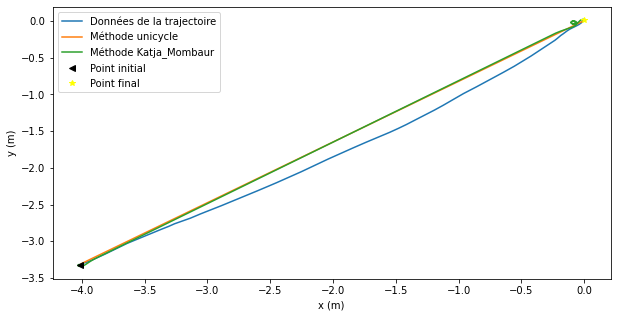

In [93]:
plt.figure(figsize = (10,5))
plt.plot(X1,X2, label = 'Données de la trajectoire' )
plt.plot(X1_S1,X2_S1, label = 'Méthode unicycle')
plt.plot(X_S1,Y_S1, label = 'Méthode Katja_Mombaur')


plt.plot(Xi[0],Xi[1], '<', label = 'Point initial', color = 'black')
plt.plot(Xf[0],Xf[1], '*', label = 'Point final', color = 'yellow')

plt.ylabel("y (m)")
plt.xlabel("x (m)")

plt.legend()